In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
install.packages("GGally")
library("GGally")
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [53]:
# loads data from the original source on the web 
shoppers_data_full <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv")

# convert our target variable as a factor
shoppers_data <- shoppers_data_full %>% 
    mutate(Revenue = as_factor(Revenue))
shoppers_data

Parsed with column specification:
cols(
  Administrative = col_double(),
  Administrative_Duration = col_double(),
  Informational = col_double(),
  Informational_Duration = col_double(),
  ProductRelated = col_double(),
  ProductRelated_Duration = col_double(),
  BounceRates = col_double(),
  ExitRates = col_double(),
  PageValues = col_double(),
  SpecialDay = col_double(),
  Month = col_character(),
  OperatingSystems = col_double(),
  Browser = col_double(),
  Region = col_double(),
  TrafficType = col_double(),
  VisitorType = col_character(),
  Weekend = col_logical(),
  Revenue = col_logical()
)



Administrative Administrative_Duration Informational
1     0              0                       0            
2     0              0                       0            
3     0              0                       0            
⋮     ⋮              ⋮                       ⋮            
12328 0               0                      0            
12329 4              75                      0            
12330 0               0                      0            
      Informational_Duration ProductRelated ProductRelated_Duration BounceRates
1     0                      1               0                      0.2        
2     0                      2              64                      0.0        
3     0                      1               0                      0.2        
⋮     ⋮                      ⋮              ⋮                       ⋮          
12328 0                       6             184.25                  0.08333333 
12329 0                      15             346.00                  0.00000000 
12330 0                       3              21.25                  0.00000000 
      ExitRates  PageValues SpecialDay Month OperatingSystems Browser Region
1     0.2        0          0          Feb   1                1       1     
2     0.1        0          0          Feb   2                2       1     
3     0.2        0          0          Feb   4                1       9     
⋮     ⋮          ⋮          ⋮          ⋮     ⋮                ⋮       ⋮     
12328 0.08666667 0          0          Nov   3                2       1     
12329 0.02105263 0          0          Nov   2                2       3     
12330 0.06666667 0          0          Nov   3                2       1     
      TrafficType VisitorType       Weekend Revenue
1     1           Returning_Visitor FALSE   FALSE  
2     2           Returning_Visitor FALSE   FALSE  
3     3           Returning_Visitor FALSE   FALSE  
⋮     ⋮           ⋮                 ⋮       ⋮      
12328 13          Returning_Visitor  TRUE   FALSE  
12329 11          Returning_Visitor FALSE   FALSE  
12330  2          New_Visitor        TRUE   FALSE

In [54]:
# count the observations in two levels of Revenue and identify the existence of imbalance
shoppers_summary <- shoppers_data %>% 
    group_by(Revenue) %>% 
    summarize(observations = n()) 
shoppers_summary
# up sampling is required for further analysis

`summarise()` ungrouping output (override with `.groups` argument)



Revenue observations
1 FALSE   10422       
2 TRUE     1908

Warning message in ggcorr(shoppers_data_numeric, hjust = 1, size = 4, label = TRUE):
“data in column(s) 'Month', 'VisitorType', 'Weekend' are not numeric and were ignored”


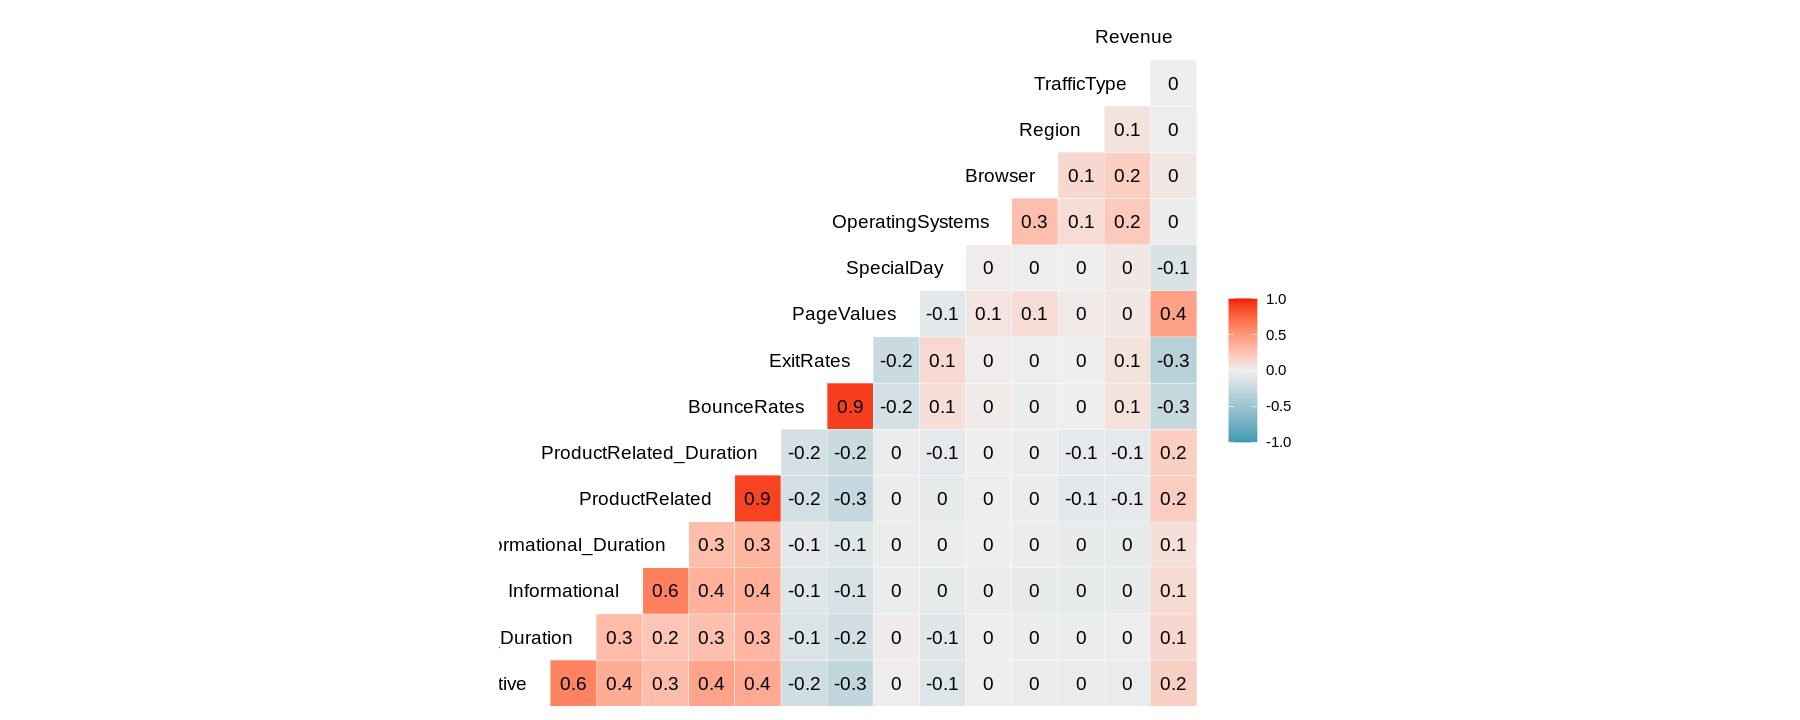

In [55]:
# upsampling is applied on the data
shoppers_recipe <- recipe(Revenue ~ ., data = shoppers_data) %>% 
     step_upsample(Revenue, over_ratio = 1, skip = FALSE) %>% 
     prep()
shoppers_data_upsampled <- bake(shoppers_recipe,shoppers_data)

# change the Revenue into a numeric value
shoppers_data_numeric <- shoppers_data_upsampled %>% 
    mutate(Revenue = ifelse(Revenue==TRUE, 1, 0)) 

#  the visualization of correlation coefficients between each numerical variable in our data and our target, Revenue
shoppers_cor <- ggcorr(shoppers_data_numeric, hjust = 1, size = 4,label = TRUE)
shoppers_cor

In [58]:
# Choose the top three variables as predictors with the largest corrlation coefficient
shoppers_data <- shoppers_data %>% 
    select(BounceRates, ExitRates, PageValues, Revenue)
shoppers_data

BounceRates ExitRates  PageValues Revenue
1     0.2         0.2        0          FALSE  
2     0.0         0.1        0          FALSE  
3     0.2         0.2        0          FALSE  
⋮     ⋮           ⋮          ⋮          ⋮      
12328 0.08333333  0.08666667 0          FALSE  
12329 0.00000000  0.02105263 0          FALSE  
12330 0.00000000  0.06666667 0          FALSE

In [60]:
set.seed(100)

# split the original data into training set and test set
shoppers_split <- initial_split(data = shoppers_data,
                                prop = 0.75,
                                strate = Revenue)

shoppers_training <- training(shoppers_split)
shoppers_testing <- testing(shoppers_split)

shoppers_analysis_recipe <- recipe(Revenue ~ ., data = shoppers_training) %>%
    step_upsample(Revenue, over_ratio = 1, skip = FALSE) %>% 
    prep()
shoppers_training_upsampled <- bake(shoppers_analysis_recipe,shoppers_training)

# check if training set is balanced
summary(shoppers_training_upsampled$Revenue)

FALSE  TRUE 
 7831  7831

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



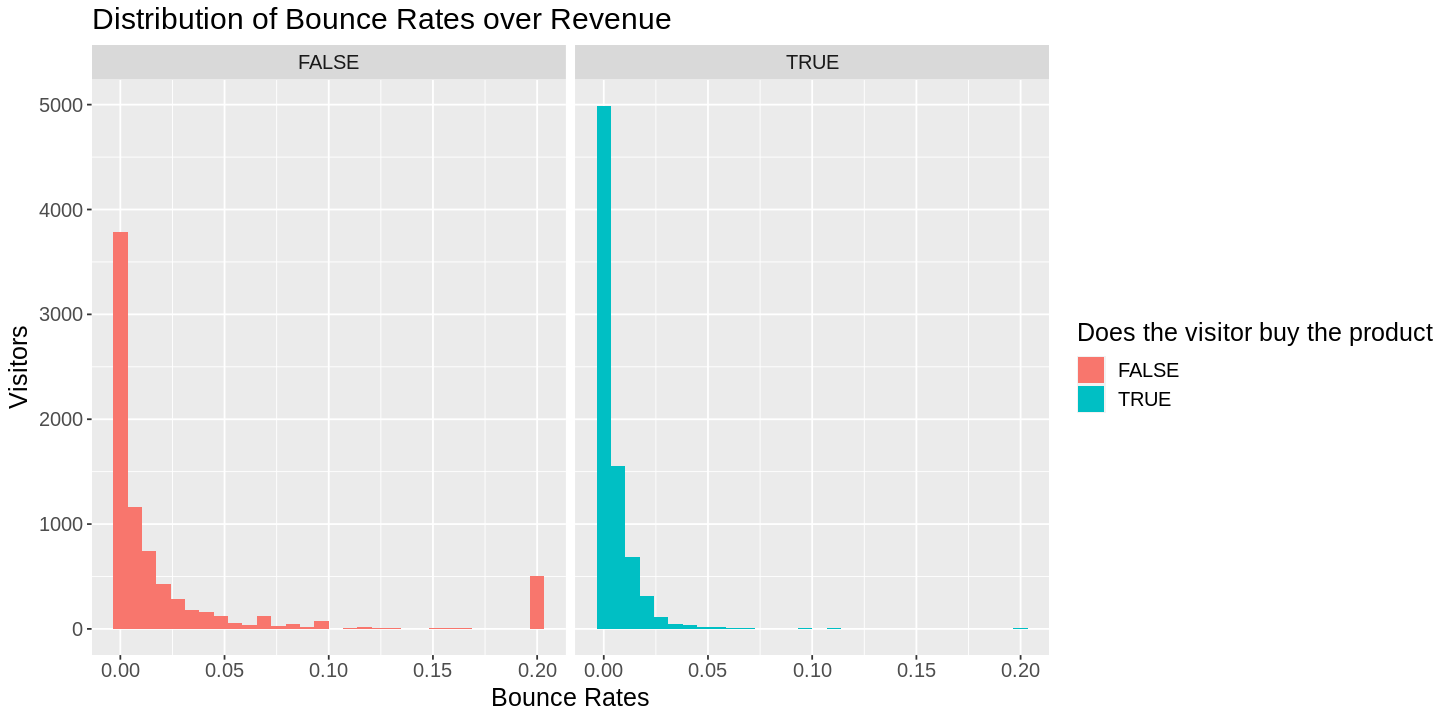

In [61]:
options(repr.plot.height = 6, repr.plot.width = 12)
bounce_hist <- ggplot(shoppers_training_upsampled, aes(x = BounceRates, fill = Revenue)) +
    geom_histogram(position = "identity") +
    facet_grid(. ~ Revenue)+
    labs(x = "Bounce Rates", y = "Visitors", fill = "Does the visitor buy the product",title="Distribution of Bounce Rates over Revenue") +
    theme(text = element_text(size = 15))
bounce_hist

Figure 1: Histogram of Bounce Rates split horizontally by revenue (training set)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



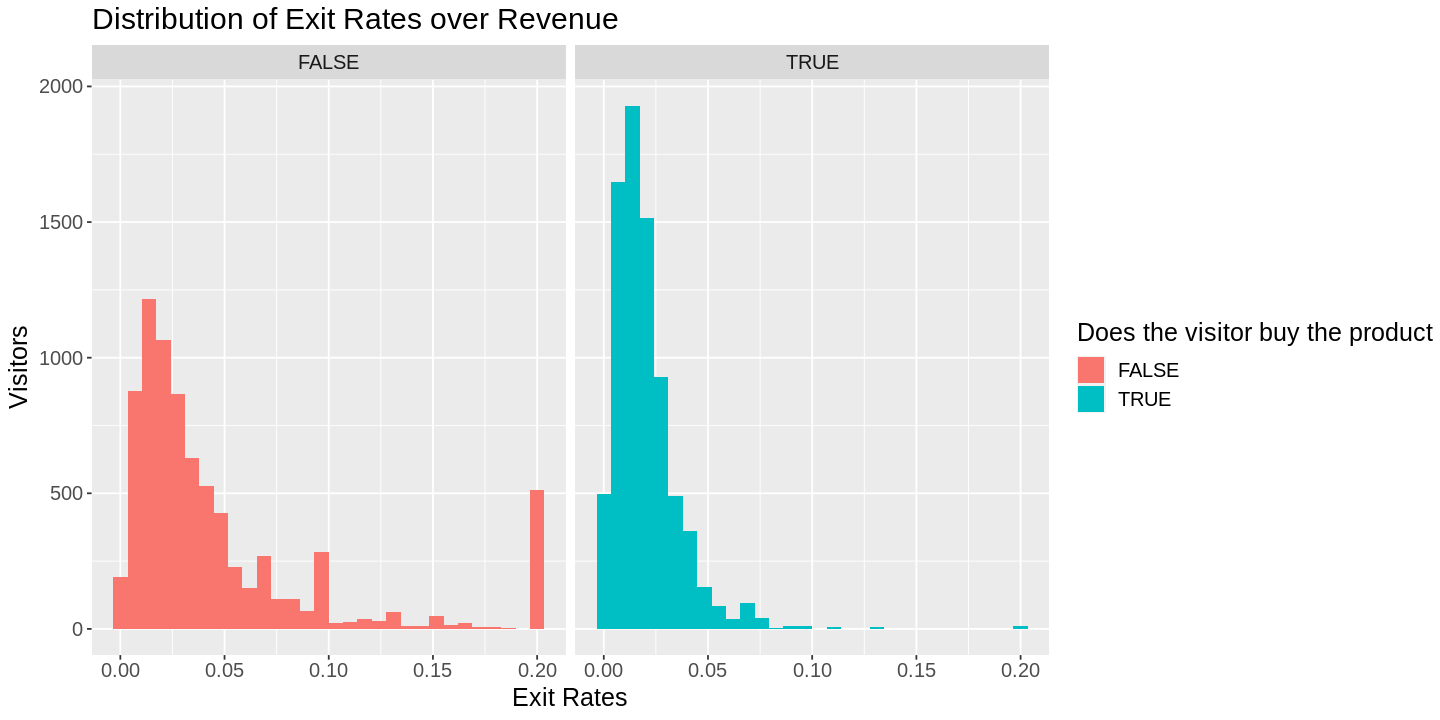

In [62]:
options(repr.plot.height = 6, repr.plot.width = 12)
exit_hist <- ggplot(shoppers_training_upsampled, aes(x = ExitRates, fill = Revenue)) +
    geom_histogram(position = "identity") +
    facet_grid(. ~ Revenue)+
    labs(x = "Exit Rates", y = "Visitors", fill = "Does the visitor buy the product",title="Distribution of Exit Rates over Revenue") +
    theme(text = element_text(size = 15))
exit_hist

Figure 2: Histogram of Exit Rates split horizontally by revenue (training set)

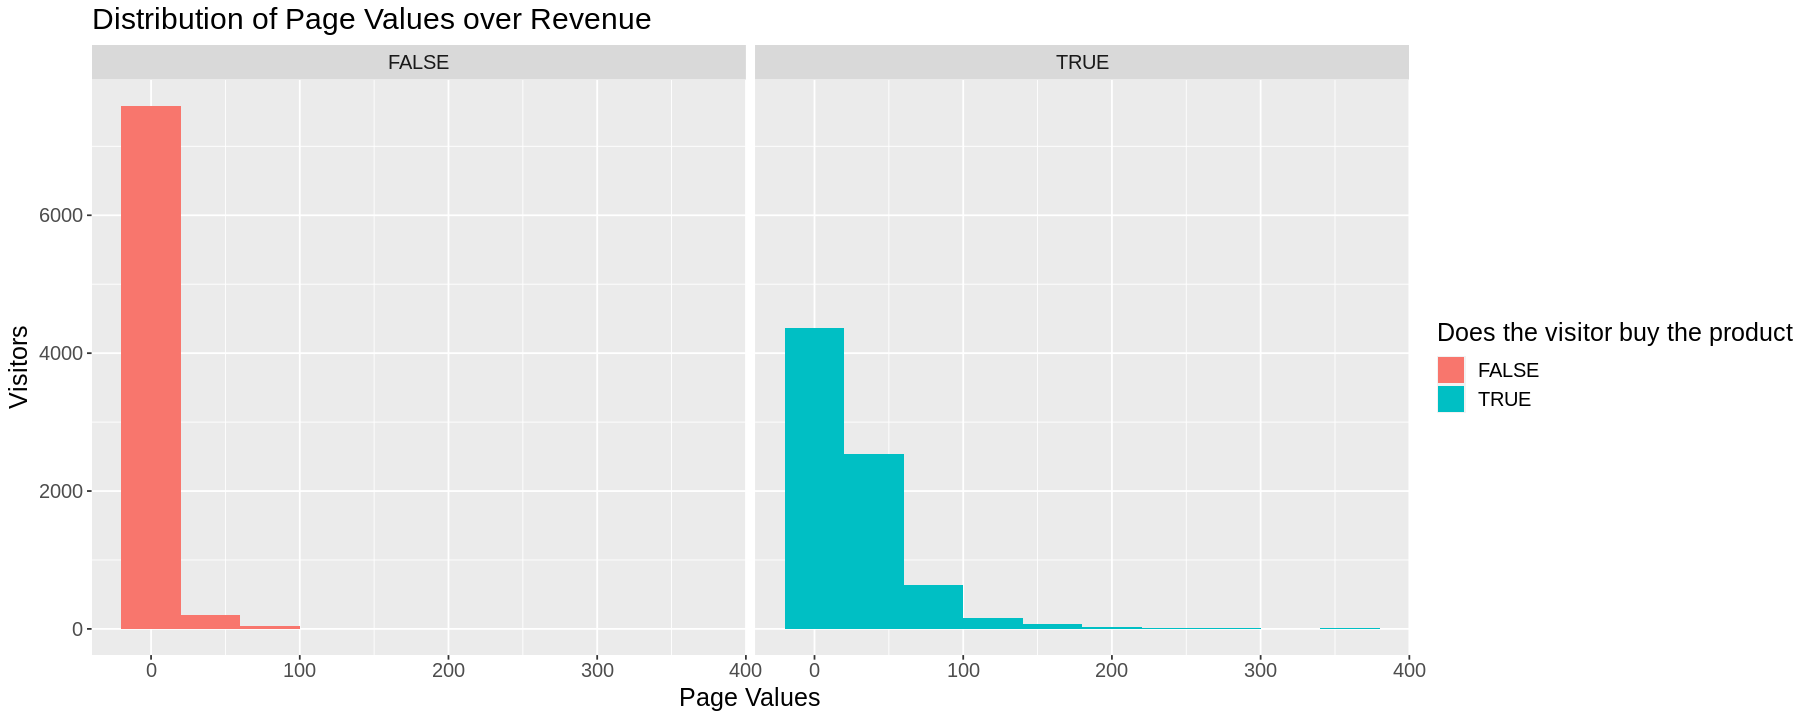

In [63]:
options(repr.plot.height = 6, repr.plot.width = 15)
page_values_hist <- ggplot(shoppers_training_upsampled, aes(x = PageValues, fill = Revenue)) +
    geom_histogram(position = "identity",binwidth=40) +
    facet_grid(. ~ Revenue)+
    labs(x = "Page Values", y = "Visitors", fill = "Does the visitor buy the product",title="Distribution of Page Values over Revenue") +
    theme(text = element_text(size = 15))
page_values_hist

Figure 3: Histogram of Page Values split horizontally by revenue (training set)

In [65]:
# scale and center the training set for k-nearest neighbors algorithm
shoppers_recipe <- recipe(Revenue ~ ., data = shoppers_training_upsampled) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 


In [66]:
# tune the classifier by cross validation
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

shoppers_vfold <- vfold_cv(shoppers_training_upsampled, v = 5, strata = Revenue)

shoppers_workflow <- workflow() %>%
    add_recipe(shoppers_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = shoppers_vfold,
              grid = tibble(neighbors = seq(1, 20, 1))) %>%
    collect_metrics()
shoppers_workflow

neighbors .metric  .estimator mean      n std_err      .config
1  1         accuracy binary     0.9247221 5 0.0005605716 Model01
2  1         roc_auc  binary     0.9247221 5 0.0005605716 Model01
3  2         accuracy binary     0.9249778 5 0.0010939837 Model02
⋮  ⋮         ⋮        ⋮          ⋮         ⋮ ⋮            ⋮      
38 19        roc_auc  binary     0.9053651 5 0.002116196  Model19
39 20        accuracy binary     0.8422935 5 0.002590750  Model20
40 20        roc_auc  binary     0.9047428 5 0.002080871  Model20

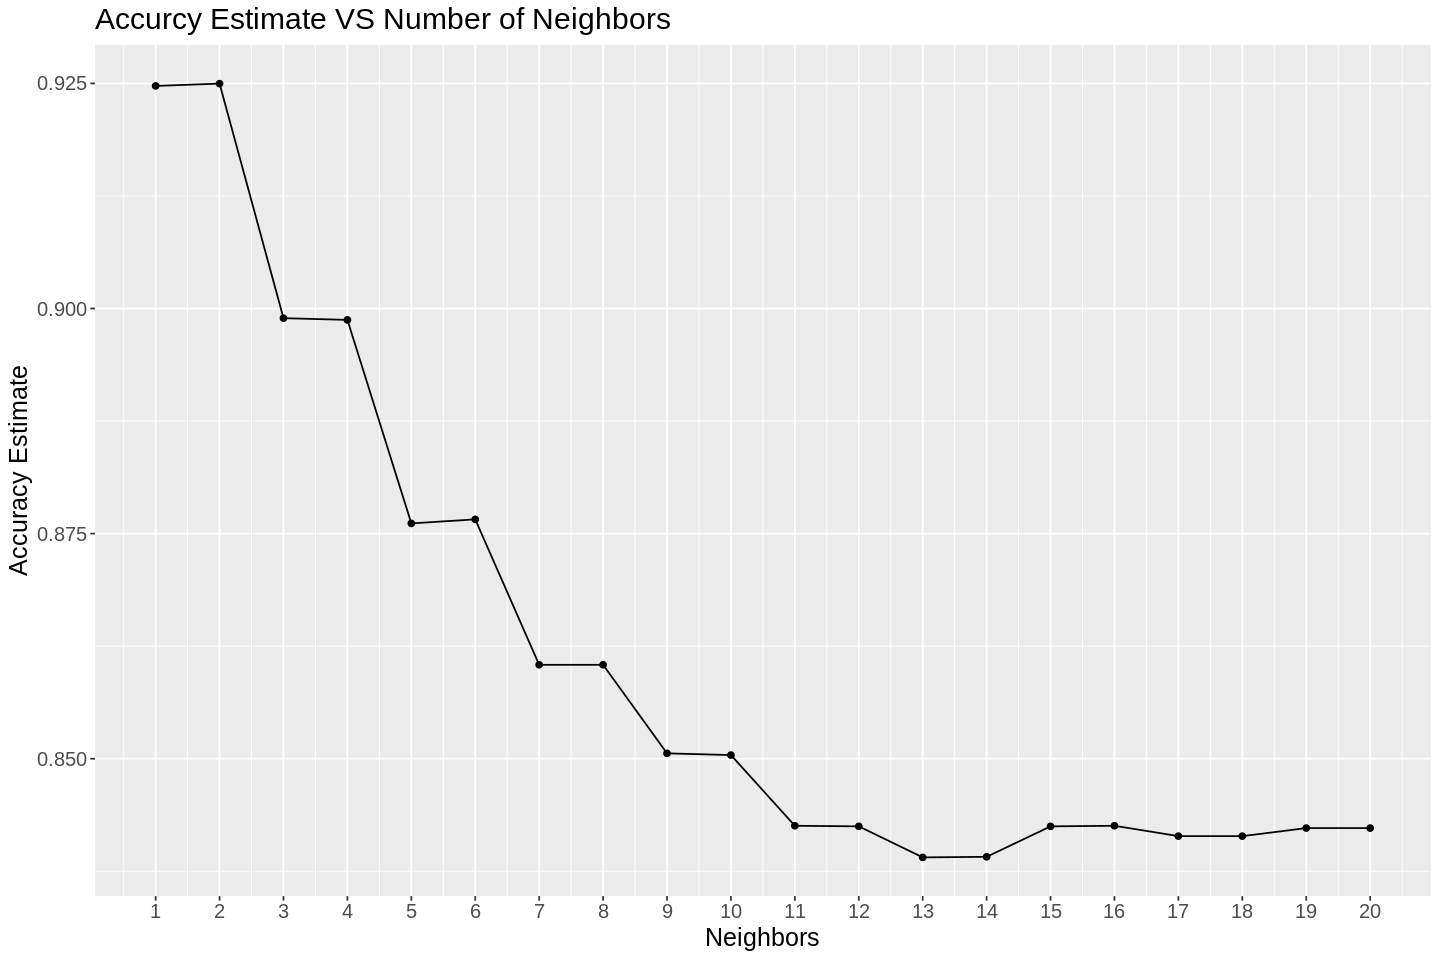

In [115]:
# visualize the relationship between number of neighbors and estimate accuracy
shoppers_accuracy <- shoppers_workflow %>%
    filter(.metric == 'accuracy') %>%
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        scale_x_continuous(breaks = seq(1, 20, by = 1)) +
        labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accurcy Estimate VS Number of Neighbors") + 
        theme(text = element_text(size = 15))
shoppers_accuracy

Figure 4: Scatter plot and line plot of accuracy estimate versus number of neighbours

In [68]:
# choose k = 2 and rebuild the model
knn_spec_k2 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 2) %>%
    set_engine('kknn') %>%
    set_mode('classification')

shoppers_workflow_k2 <- workflow() %>%
    add_recipe(shoppers_recipe) %>%
    add_model(knn_spec_k2) %>%
    fit(data = shoppers_training_upsampled)


In [69]:
# make prediction on test set and bind the prediction to it
prediction <- shoppers_workflow_k2 %>%
    predict(shoppers_testing) %>%
    bind_cols(shoppers_testing)

# calculate the accuracy
prediction_metrics <- prediction %>%
    metrics(truth = Revenue, estimate = .pred_class)   

prediction_metrics

.metric  .estimator .estimate
1 accuracy binary     0.8637249
2 kap      binary     0.4756724

In [72]:
shoppers_mat <- prediction %>%
      conf_mat(truth = Revenue, estimate = .pred_class) 

shoppers_mat

          Truth
Prediction FALSE TRUE
     FALSE  2399  228
     TRUE    192  263

In [82]:
# create the grid of area/smoothness vals, and arrange in a data frame
page_grid <- seq(min(shoppers_data$PageValues), max(shoppers_data$PageValues), length.out = 150)
bounce_grid <- seq(min(shoppers_data$BounceRates), max(shoppers_data$BounceRates), length.out = 80)
exit_grid <- seq(min(shoppers_data$ExitRates), max(shoppers_data$ExitRates), length.out = 80)
asgrid <- as_tibble(expand.grid(PageValues = page_grid, BounceRates = bounce_grid, ExitRates = exit_grid))

In [83]:
# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(shoppers_workflow_k2, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% rename(Revenue = .pred_class)

In [75]:
# mannually choosing the colors
cbPalette <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999")

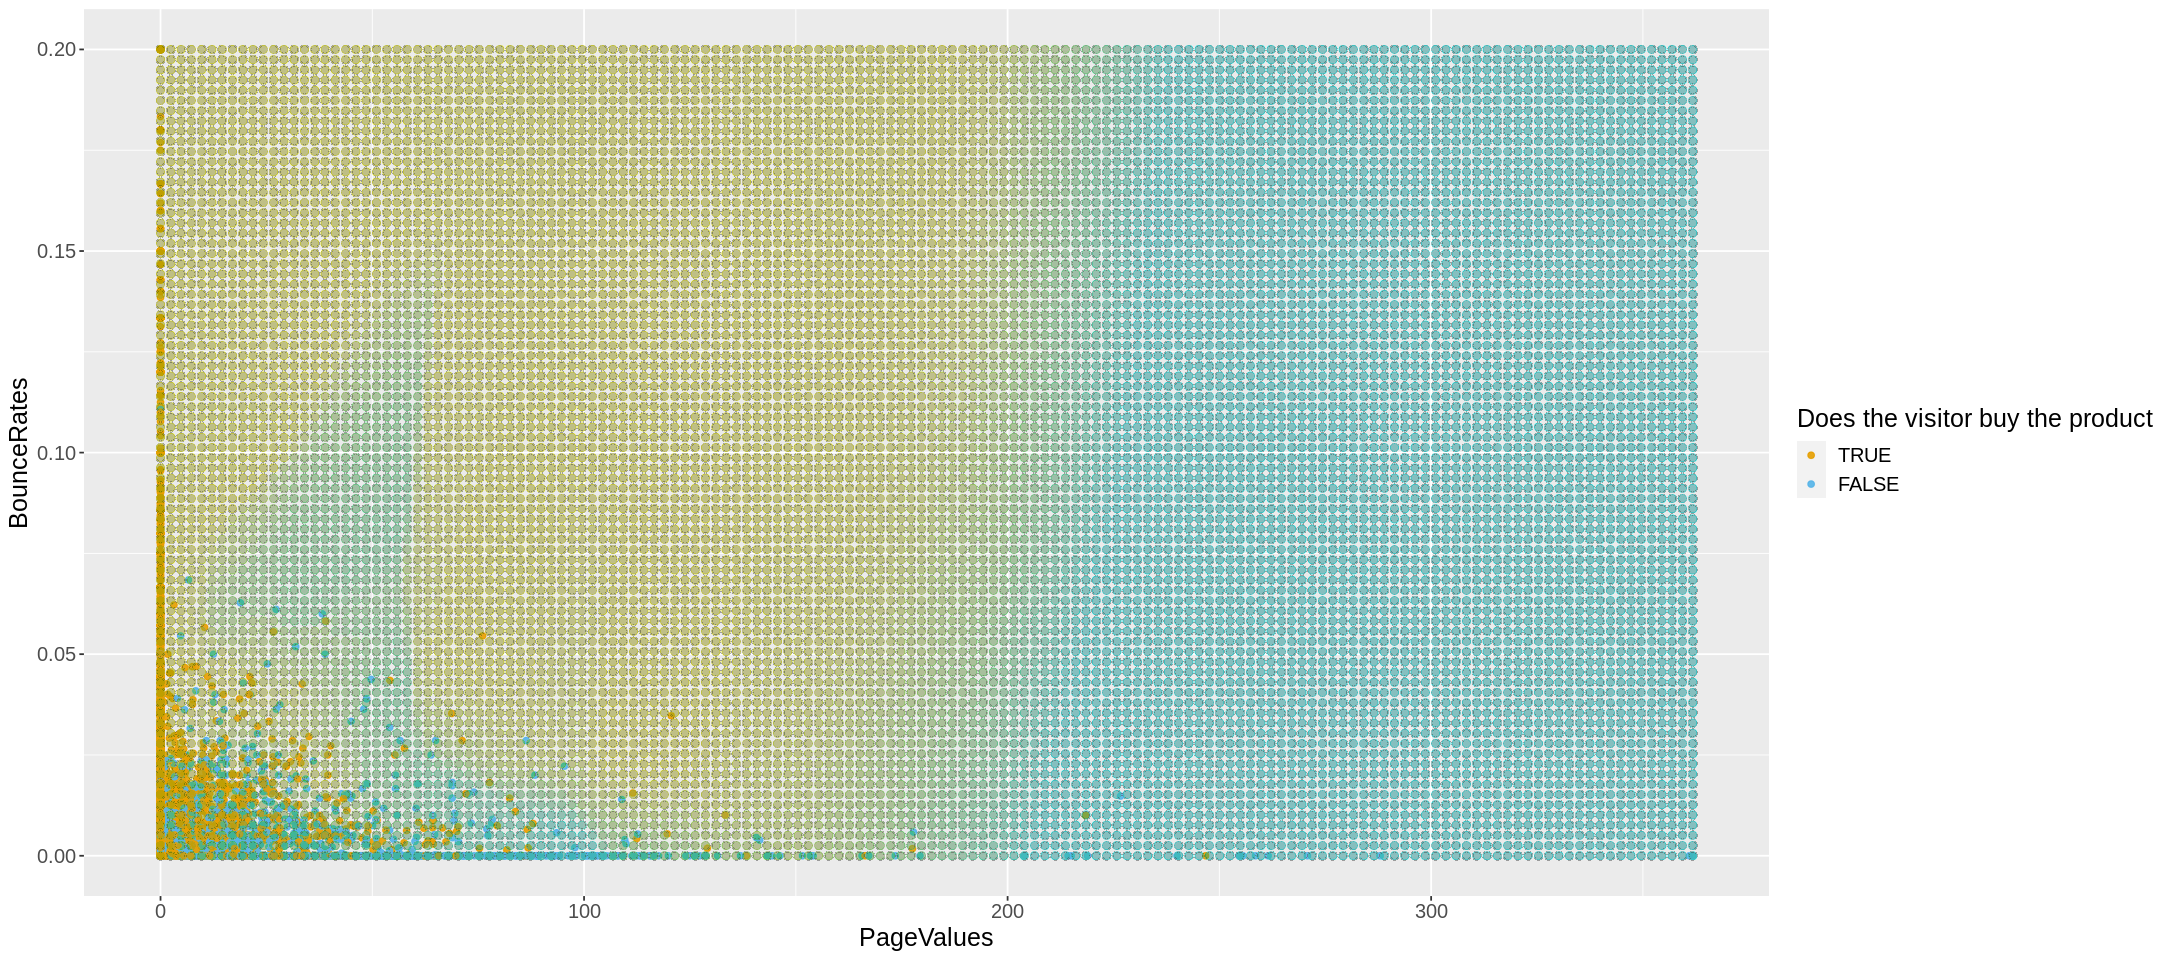

In [98]:
# plot:
# 1. the coloured scatter of the original data
# 2. the faded coloured scatter for the grid points
options(repr.plot.width = 18, repr.plot.height = 8)
page_bounce_plot <-
    ggplot() +
    geom_point(data = shoppers_data, mapping = aes(x = PageValues, y = BounceRates, color = Revenue), alpha = 0.9) +
    geom_point(data = prediction_table, mapping = aes(x = PageValues, y = BounceRates, color = Revenue), alpha = 0.006, size = 2.) +
    labs(color = "Does the visitor buy the product") +
    scale_color_manual(labels = c("TRUE", "FALSE"), values = cbPalette) + 
    theme(text = element_text(size = 15))
page_bounce_plot

Figure 5: Scatterplot of Bounce Rates versus Page Values where background colour indicates the decision of the classifier

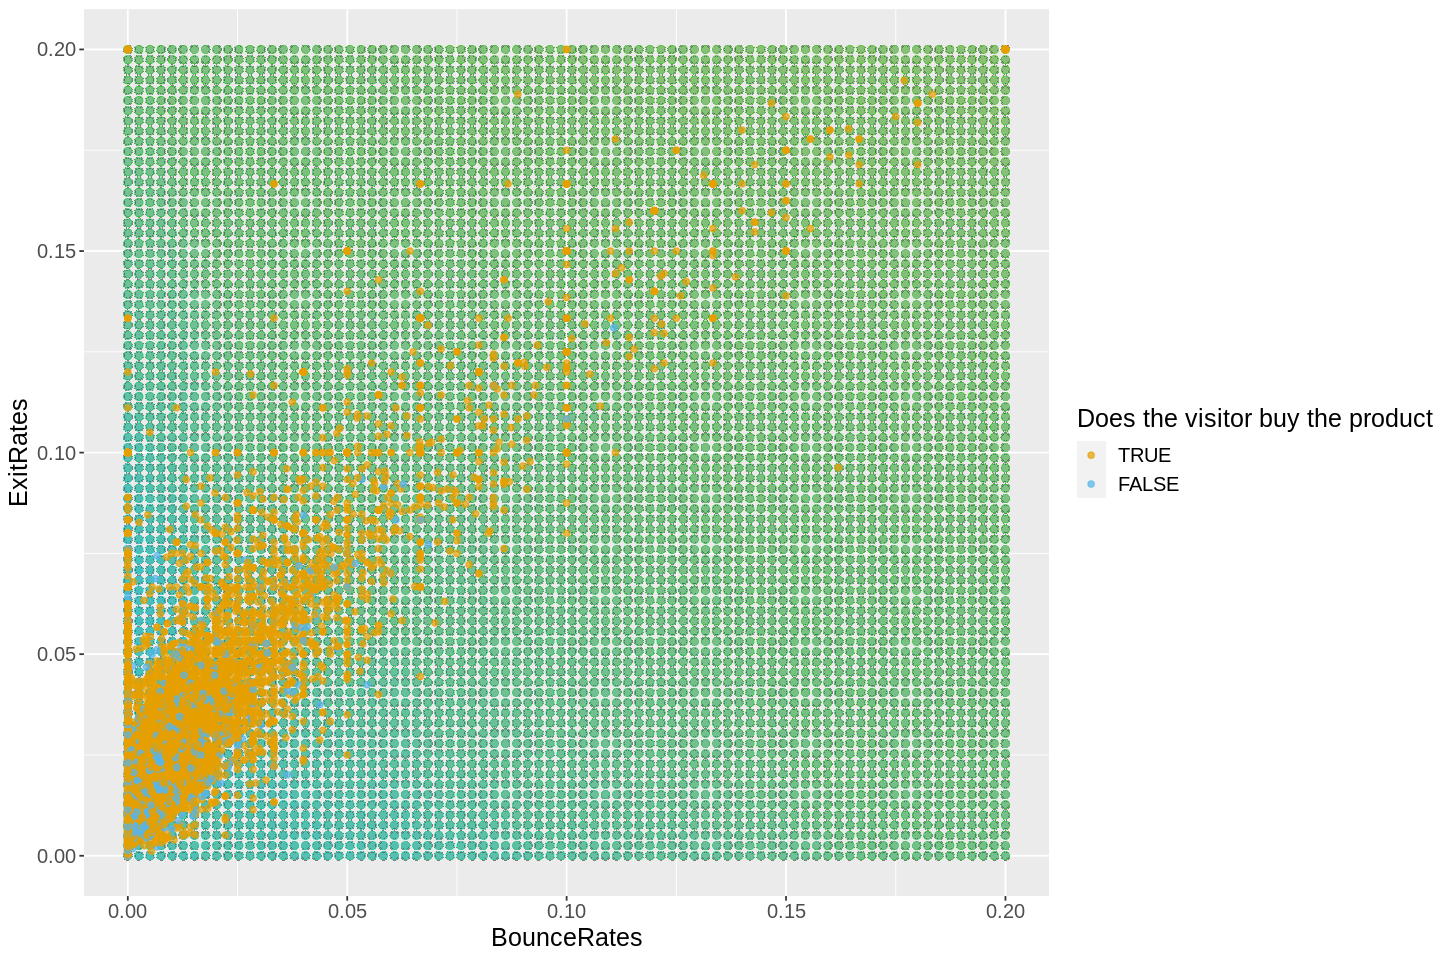

In [114]:
# plot:
# 1. the coloured scatter of the original data
# 2. the faded coloured scatter for the grid points
options(repr.plot.width = 12, repr.plot.height = 8)

bounce_exit_plot <-
  ggplot() +
  geom_point(data = prediction_table, mapping = aes(x = BounceRates, y = ExitRates, color = Revenue), alpha = 0.006, size = 2.) +
  geom_point(data = shoppers_data, mapping = aes(x = BounceRates, y = ExitRates, color = Revenue), alpha = 0.7) +
  labs(color = "Does the visitor buy the product") +
  scale_color_manual(labels = c("TRUE", "FALSE"), values = cbPalette)+ 
theme(text = element_text(size = 15))
bounce_exit_plot

Figure 6: Scatterplot of Exit Rates versus Bounce Rates where background colour indicates the decision of the classifier

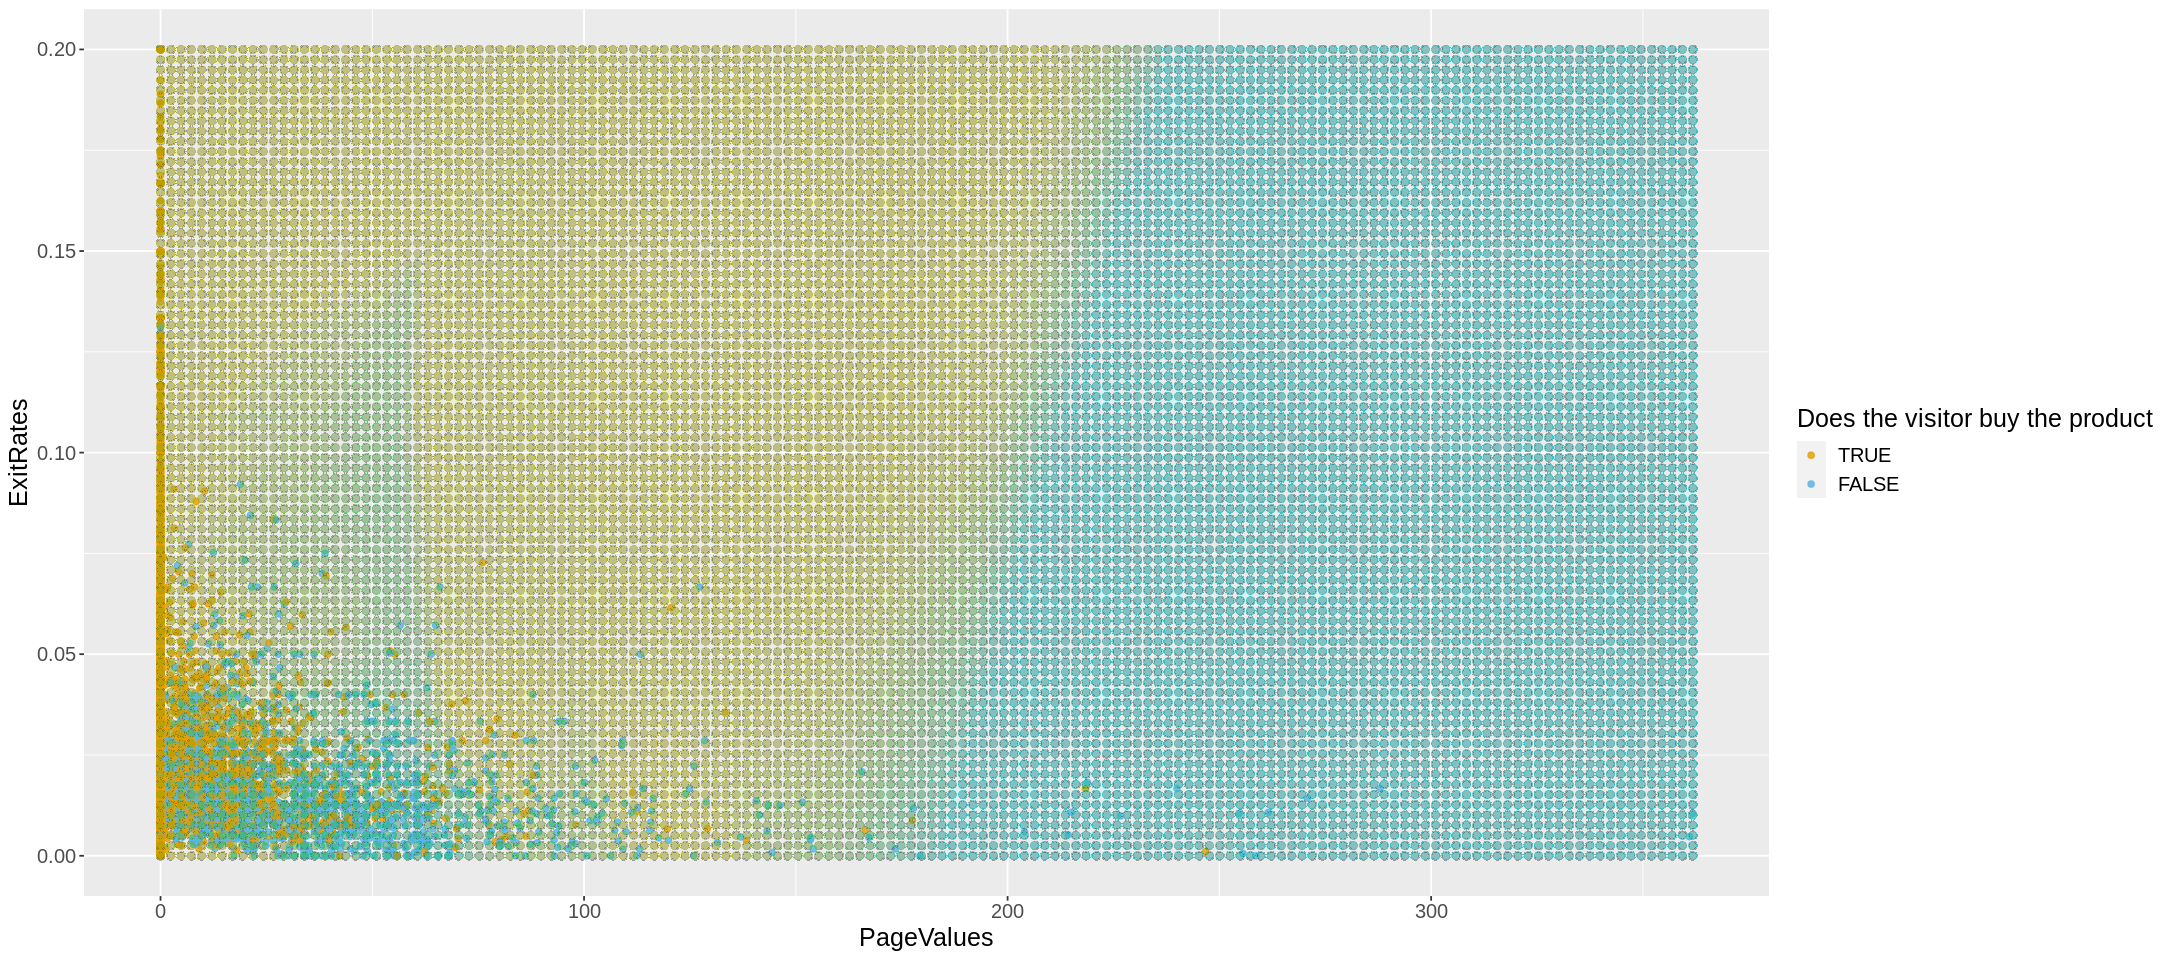

In [108]:
# plot:
# 1. the coloured scatter of the original data
# 2. the faded coloured scatter for the grid points
options(repr.plot.width = 18, repr.plot.height = 8)

page_exit_plot <-
  ggplot() +
  geom_point(data = shoppers_data, mapping = aes(x = PageValues, y = ExitRates, color = Revenue), alpha = 0.8) +
  geom_point(data = prediction_table, mapping = aes(x = PageValues, y = ExitRates, color = Revenue), alpha = 0.006, size = 2.) +
  labs(color = "Does the visitor buy the product") +
  scale_color_manual(labels = c("TRUE", "FALSE"), values = cbPalette)+ 
  theme(text = element_text(size = 15))
page_exit_plot

Figure 6: Scatterplot of Exit Rates versus Page Values where background colour indicates the decision of the classifier